# Dependencies

In [2]:
# Audio
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from torchvggish import vggish, vggish_input
import torch.nn.functional as F
import matplotlib.pyplot as plt
import librosa.display
from sklearn.model_selection import train_test_split

# Lyrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import DebertaV2TokenizerFast, DebertaV2ForSequenceClassification, Trainer, TrainingArguments
from tabulate import tabulate
from collections import Counter

E:\CS760-Music-Emotion-Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Audio Model
## Created by Andrew

In [3]:
#Load Data
df = pd.read_csv('multimodal_dataset_normalized.csv')
display(df.head())

,Audio_Song,Lyric_Song,Arousal,Valence,Quadrant,Emotion,lyric_id,word_count,unique_word_count,lexical_diversity,...,rms_mean,rms_std,beat_strength,low_energy_ratio,energy_entropy,brightness,warmth,activity,harmonic_energy_ratio,harmonicity
0,A005,L055,0.78750,0.68750,Q1,Surprise,L055,0.583846,-0.032136,-1.136493,...,-1.315662,-1.165455,0.896397,-0.700513,-0.145042,1.086334,-0.092941,[0.06471955],-1.951364,-0.583475
1,A011,L061,0.68125,0.85625,Q1,Happiness,L061,-0.549140,-0.974930,-1.286263,...,0.107522,-0.408386,0.006682,0.068631,0.750471,0.147696,0.040220,[0.18521025],0.472448,-0.078961
2,A014,L064,0.86250,0.72500,Q1,Surprise,L064,0.415581,-0.162177,-1.133997,...,0.361195,-0.265328,0.710477,-0.673247,0.854382,1.970159,-0.798261,[0.17745368],-0.949336,-0.454885
3,A019,L069,0.78125,0.81875,Q1,Excitement,L069,-0.229436,-0.308472,-0.401603,...,-0.219121,-0.979168,-0.061622,-0.340510,1.062094,0.474343,0.110013,[0.13742129],0.244760,-0.150335
4,A022,L072,0.76875,0.83750,Q1,Excitement,L072,-0.599619,-0.828634,-0.755787,...,0.916902,0.959027,-0.008507,-0.482841,0.298920,-0.169472,0.269772,[0.22606403],-0.078616,-0.234134


In [4]:
#Emotion Class
unique_items = df["Quadrant"].unique()
print(unique_items)

['Q1' 'Q2' 'Q3' 'Q4']


In [5]:
#Extract path and emotion
data_dir = "MERGE_Bimodal_Complete/audio"
labels_dict = {f"{row['Quadrant']}/{row['Audio_Song']}.mp3": row['Quadrant']
               for _, row in df.iterrows()}
print(labels_dict)

{'Q1/A005.mp3': 'Q1', 'Q1/A011.mp3': 'Q1', 'Q1/A014.mp3': 'Q1', 'Q1/A019.mp3': 'Q1', 'Q1/A022.mp3': 'Q1', 'Q1/A024.mp3': 'Q1', 'Q1/A039.mp3': 'Q1', 'Q1/A042.mp3': 'Q1', 'Q1/A043.mp3': 'Q1', 'Q1/A047.mp3': 'Q1', 'Q1/A050.mp3': 'Q1', 'Q1/A064-116.mp3': 'Q1', 'Q1/A077-122.mp3': 'Q1', 'Q1/A086-123.mp3': 'Q1', 'Q1/A092-96.mp3': 'Q1', 'Q1/A094-110.mp3': 'Q1', 'Q1/A095-113.mp3': 'Q1', 'Q1/A100-124.mp3': 'Q1', 'Q1/A101-111.mp3': 'Q1', 'Q1/A102-114.mp3': 'Q1', 'Q1/A104-119.mp3': 'Q1', 'Q1/A105-117.mp3': 'Q1', 'Q1/A107-115.mp3': 'Q1', 'Q1/A114-120.mp3': 'Q1', 'Q1/A115-84.mp3': 'Q1', 'Q1/A128-109.mp3': 'Q1', 'Q1/A132-121.mp3': 'Q1', 'Q1/A146-118.mp3': 'Q1', 'Q1/A148-102.mp3': 'Q1', 'Q1/A152-108.mp3': 'Q1', 'Q1/A153-130.mp3': 'Q1', 'Q1/A160-149.mp3': 'Q1', 'Q1/A162.mp3': 'Q1', 'Q1/A166.mp3': 'Q1', 'Q1/A167.mp3': 'Q1', 'Q1/A187.mp3': 'Q1', 'Q1/A196.mp3': 'Q1', 'Q1/MT0000040773.mp3': 'Q1', 'Q1/MT0000045345.mp3': 'Q1', 'Q1/MT0000080053.mp3': 'Q1', 'Q1/MT0000091401.mp3': 'Q1', 'Q1/MT0000093583.mp3': '

In [6]:
#Settings
duration = 30
sr = 16000
num_classes = 4
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Data Preprocessing
X_list = []
y_list = []


target_frames = 1876
all_classes = ['Q1', 'Q2', 'Q3', 'Q4']
class_to_idx = {cls: i for i, cls in enumerate(all_classes)}
print("Class to index mapping:", class_to_idx)


for file, label in labels_dict.items():
    filepath = os.path.join(data_dir, file)
    y, _ = librosa.load(filepath, sr=sr, duration=duration)

    # VGGish preprocessing: convert waveform to log-mel spectrogram
    mel = vggish_input.waveform_to_examples(y, sr)

    # mel shape: (num_patches, 1, 96, 64)
    mel_tensor = torch.tensor(mel, dtype=torch.float32)

    # Average over patches to get single embedding per clip
    mel_tensor = mel_tensor.mean(dim=0, keepdim=True)  # shape: (1, 1, 96, 64)

    X_list.append(mel_tensor)
    y_list.append(class_to_idx[label])

X = torch.cat(X_list, dim=0)  # shape: (N, 1, 96, 64)
y = torch.tensor(y_list, dtype=torch.long)

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Class to index mapping: {'Q1': 0, 'Q2': 1, 'Q3': 2, 'Q4': 3}


C:\Users\GGPC\AppData\Local\Temp\ipykernel_1752\226472486.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mel_tensor = torch.tensor(mel, dtype=torch.float32)


Train shape: torch.Size([1329, 1, 96, 64]) torch.Size([1329])
Val shape: torch.Size([443, 1, 96, 64]) torch.Size([443])
Test shape: torch.Size([444, 1, 96, 64]) torch.Size([444])


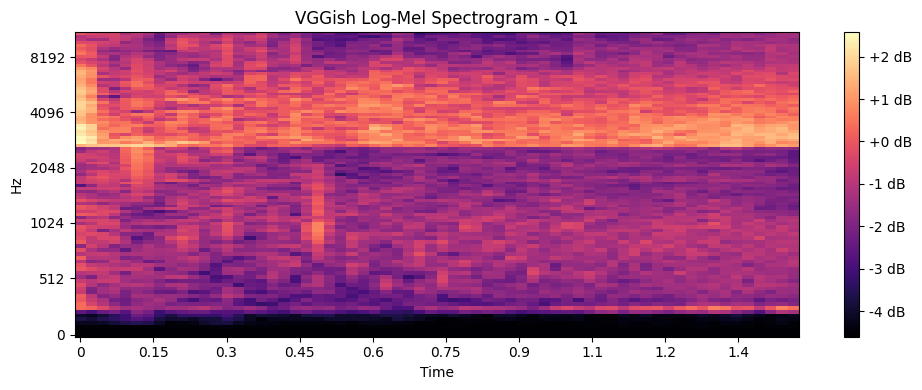

In [7]:
# Take the first audio clip
file, label = list(labels_dict.items())[0]
filepath = os.path.join(data_dir, file)
y, _ = librosa.load(filepath, sr=16000, duration=duration)

# Convert waveform to VGGish log-mel spectrogram
mel_patches = vggish_input.waveform_to_examples(y, sr)  # (num_patches, 1, 96, 64)

# Pick the first patch for visualization
mel_example = mel_patches[0, 0, :, :]  # (96, 64)

# Detach and convert to NumPy
if isinstance(mel_example, torch.Tensor):
    mel_example = mel_example.detach().numpy()

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_example, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title(f"VGGish Log-Mel Spectrogram - {label}")
plt.tight_layout()
plt.show()

In [8]:
#load pretrained
vgg_model = vggish()
vgg_model.eval()
vgg_model.to(device)

# Freeze VGGish layers
for param in vgg_model.parameters():
    param.requires_grad = False

# Patch VGG pca
vgg_model.pproc._pca_matrix = vgg_model.pproc._pca_matrix.to(device)
vgg_model.pproc._pca_means = vgg_model.pproc._pca_means.to(device)


# Add FC classifier for emotions
fc_model = nn.Sequential(
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(32, num_classes)
).to(device)

In [9]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fc_model.parameters(), lr=1e-3)
num_epochs = 30
for epoch in range(num_epochs):
    #Training
    fc_model.train()        # train FC only

    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        with torch.no_grad():
            vgg_model.eval()
            embeddings = vgg_model(X_batch)  # shape: (batch, 128)

        if embeddings.ndim == 1:
            embeddings = embeddings.unsqueeze(0)  # Add batch dimension at position 0
        elif embeddings.ndim > 2:
            embeddings = embeddings.view(-1, 128)  # Flatten to [batch_size, 128]


        logits = fc_model(embeddings)
        loss = criterion(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(logits, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    #Validation
    fc_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            embeddings = vgg_model(X_batch)
            logits = fc_model(embeddings)
            loss = criterion(logits, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(logits, 1)
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/30 | Train Loss: 7.4411, Train Acc: 0.2649 | Val Loss: 1.5672, Val Acc: 0.3160
Epoch 2/30 | Train Loss: 1.4749, Train Acc: 0.2573 | Val Loss: 1.3764, Val Acc: 0.3047
Epoch 3/30 | Train Loss: 1.3532, Train Acc: 0.3115 | Val Loss: 1.2924, Val Acc: 0.3995
Epoch 4/30 | Train Loss: 1.3175, Train Acc: 0.3401 | Val Loss: 1.2577, Val Acc: 0.4153
Epoch 5/30 | Train Loss: 1.2875, Train Acc: 0.3642 | Val Loss: 1.2373, Val Acc: 0.4244
Epoch 6/30 | Train Loss: 1.3044, Train Acc: 0.3589 | Val Loss: 1.2384, Val Acc: 0.4244
Epoch 7/30 | Train Loss: 1.2699, Train Acc: 0.3732 | Val Loss: 1.1995, Val Acc: 0.4402
Epoch 8/30 | Train Loss: 1.2879, Train Acc: 0.3476 | Val Loss: 1.1956, Val Acc: 0.4357
Epoch 9/30 | Train Loss: 1.2629, Train Acc: 0.3664 | Val Loss: 1.2170, Val Acc: 0.4334
Epoch 10/30 | Train Loss: 1.2563, Train Acc: 0.3770 | Val Loss: 1.1949, Val Acc: 0.4492
Epoch 11/30 | Train Loss: 1.2670, Train Acc: 0.3695 | Val Loss: 1.2075, Val Acc: 0.4357
Epoch 12/30 | Train Loss: 1.2512, Train A

In [13]:
#Testing
fc_model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        embeddings = vgg_model(X_batch)
        if embeddings.ndim == 1:
            embeddings = embeddings.unsqueeze(0)
        elif embeddings.ndim > 2:
            embeddings = embeddings.view(-1, 128)
        logits = fc_model(embeddings)
        _, predicted = torch.max(logits, 1)

        test_total += y_batch.size(0)
        test_correct += (predicted == y_batch).sum().item()

test_acc = test_correct / test_total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.4842


In [16]:
# Wrapper class to extract pseudo attention weights
class VGGishWithAttention(nn.Module):
    def __init__(self, vggish_model, embed_dim):
        super().__init__()
        self.vggish = vggish_model
        self.attn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.Tanh(),
            nn.Linear(embed_dim, 1)
        )

    def forward(self, x):
        features = self.vggish(x)  # shape: [B, T, D]
        print(features.shape)
        attn_scores = self.attn(features).squeeze(-1)  # shape: [B, T]
        attn_weights = F.softmax(attn_scores, dim=-1)  # shape: [B, T]
        return features, attn_weights

In [17]:
# Get final states and attention weights
vggish_model = VGGishWithAttention(vgg_model, embed_dim=128)
vggish_model.to(device)

x_audio_batches = []
a_audio_batches = []

with torch.no_grad():
    for audio_input, labels in train_loader:
        audio_input = audio_input.to(device)
        features, attn_weights = vggish_model(audio_input)  # features: [B, T, D], attn_weights: [B, T]

        x_audio_batches.append(features.cpu())       # Optional: move to CPU
        a_audio_batches.append(attn_weights.cpu())

# Concatenate across batches
x_audio = torch.cat(x_audio_batches, dim=0)  # shape: [total_samples, T, D]
a_audio = torch.cat(a_audio_batches, dim=0)  # shape: [total_samples, T]
    
print("Done!")

print("Raw Tensors:")
print(x_audio)
print(a_audio)

print("Shapes:")
print(x_audio.shape)
print(a_audio.shape)

torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([49, 128])
Done!
Raw Tensors:
tensor([[165.,   3., 146.,  ...,  60.,   0., 255.],
        [166.,   1., 150.,  ..., 143.,  15., 255.],
        [168.,   1., 150.,  ..., 120.,   0., 255.],
        ...,
        [169.,   1., 150.,  ..., 174.,   0., 255.],
        [165.,   3., 146.,  ...,  70., 135., 255.],
        [166.,   2., 149.,  ..., 180.,   0., 255.]])
tensor([0.0115, 0.0140, 0.0150,  ..., 0.0181, 0.0163, 0.0223])
Shapes:
torch.Size([1329, 128])
torch.Size([1329])


# Lyric Model
## By Logan
( Currently still in ./LyricModel.ipynb )

In [ ]:
%run ./LyricModel.ipynb